In [1]:
# 基础包
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import numpy as np
import os
#import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline  

# xgb
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import imblearn
from imblearn.combine import SMOTEENN
from xgboost import plot_importance
# sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
# 自函数包
import function_use as fu

In [1]:
# 绝对路径
# data_path = ''
# 相对路径
# data_path = os.getcwd()
# engine ： {'c'，'python'}，可选，使用解析器引擎。C引擎速度更快，而python引擎目前功能更加完善;python会慢
# train_data = pd.read_csv(os.path.join(data_path,'train.csv'),engine = 'python')
# train_target = pd.read_csv(os.path.join(data_path,'train_target.csv'),engine = 'python')
# test_data = pd.read_csv(os.path.join(data_path,'test.csv'),engine = 'python')
# train_target_raw = pd.merge(train_raw,train_target, how='left', on=['id'])

In [2]:
# 绝对路径
data_path = '.../数据'
# 相对路径
# data_path = os.getcwd()
file_name = 'test.csv'
file_name = os.path.join(data_path,file_name)
with open(file_name,'r',encoding='utf-8') as f:
    test_raw = pd.read_csv(f)
file_name = 'train.csv'
file_name = os.path.join(data_path,file_name)
with open(file_name,'r',encoding='utf-8') as f:
    train_raw = pd.read_csv(f)
file_name = 'train_target.csv'
file_name = os.path.join(data_path,file_name)
with open(file_name,'r',encoding='utf-8') as f:
    train_target = pd.read_csv(f)
train_target_raw = pd.merge(train_raw,train_target, how='left', on=['id'])

# 0.数据清洗[缺失值,离群值]

#### 检查nan，-999
- 本数据使用-999代表nan
- 旧数据bankCard用nan表示缺失，新数据isnew=1用-999表示缺失
- nan换做-999后线下降分

In [6]:
train_have_nan = (pd.isnull(train_raw)==1).sum().to_frame()
train_have_nan.sort_values(by=0,inplace=True,ascending=0)
test_have_nan = (pd.isnull(test_raw)==1).sum().to_frame()
test_have_nan.sort_values(by=0,inplace=True,ascending=0)
train_have_nan.head(3)

,0
bankCard,20152
x_67,0
x_65,0


In [7]:
# 统一nan
train_raw.loc[:,'bankCard'][pd.isnull(train_raw.loc[:,'bankCard'])==1] = -888

In [8]:
train_have_nan = (pd.isnull(train_raw)==1).sum().to_frame()
train_have_nan.sort_values(by=0,inplace=True,ascending=0)
test_have_nan = (pd.isnull(test_raw)==1).sum().to_frame()
test_have_nan.sort_values(by=0,inplace=True,ascending=0)
train_have_nan.head(3)

,0
id,0
certId,0
x_66,0


#### 原始列分组

In [3]:
# 几个互斥分组
user_inf = ['id','gender','age','edu','highestEdu','ethnic','residentAddr','dist','job',
            'certId', 'certValidBegin', 'certValidStop']
loan_inf = ['bankCard','loanProduct','lmt','basicLevel','linkRela', 'setupHour', 'weekday','isNew']
loan_history_inf = ['ncloseCreditCard', 'unpayIndvLoan', 'unpayOtherLoan','unpayNormalLoan', '5yearBadloan']
x_inf = [f'x_{i}' for i in range(79)]
col_names_raw = user_inf + loan_inf + loan_history_inf + x_inf
train_raw = train_raw[col_names_raw]
test_raw = test_raw[col_names_raw]

#### 0.0 删除完全一样的列
- 通过corr()看出有不少变量相关系数是1，然后删除这些相同的列
- train有30个可以删除的，test有32个可以删除的，test多出来的两个不可以删除，删除后线上分数从0.77降到0.74，只删除train的30个和原始数据结果无差异
- 和之前只考虑x_比较多删除了41,43,45,61 , 这几个变量都是和loan_history_inf中的四个一模一样
    - 分别代表unpayNormalLoan,unpayIndvLoan,unpayOtherLoan,ncloseCreditCard

In [4]:
col_names = col_names_raw.copy()
del_train_col = []
for i,item_i in enumerate(col_names[:-1]):
    for j,item_j in enumerate(col_names[(i+1):]):
        if item_j not in del_train_col:
            sum_ = (train_raw[item_i] - train_raw[item_j]).sum()
            if sum_ == 0:
                del_train_col.append(item_j)
del_test_col = []
for i,item_i in enumerate(col_names[:-1]):
    for j,item_j in enumerate(col_names[(i+1):]):
        if item_j not in del_test_col:
            sum_ = (test_raw[item_i] - test_raw[item_j]).sum()
            if sum_ == 0:
                del_test_col.append(item_j)
del_train_col = list(set(del_train_col))
del_test_col = list(set(del_test_col))
print('train 可删除的数目:',len(del_train_col))
print('test 可删除的数目:',len(del_test_col))
print('test多两个可删除变量:',set(del_test_col) - set(del_train_col))
train_raw.drop(del_train_col,axis=1,inplace=True)
test_raw.drop(del_train_col,axis=1,inplace=True)

train 可删除的数目: 34
test 可删除的数目: 36
test多两个可删除变量: {'x_39', 'x_32'}


In [5]:
train_raw.columns

Index(['id', 'gender', 'age', 'edu', 'highestEdu', 'ethnic', 'residentAddr',
       'dist', 'job', 'certId', 'certValidBegin', 'certValidStop', 'bankCard',
       'loanProduct', 'lmt', 'basicLevel', 'linkRela', 'setupHour', 'weekday',
       'isNew', 'ncloseCreditCard', 'unpayIndvLoan', 'unpayOtherLoan',
       'unpayNormalLoan', '5yearBadloan', 'x_0', 'x_12', 'x_14', 'x_16',
       'x_20', 'x_22', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31',
       'x_32', 'x_33', 'x_34', 'x_35', 'x_39', 'x_42', 'x_44', 'x_46', 'x_47',
       'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56',
       'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'x_68', 'x_69', 'x_71',
       'x_72', 'x_73', 'x_74', 'x_75', 'x_76'],
      dtype='object')

### 0-1变量的衍生变量

In [6]:
# x类变量有几个是1
use_col = list(set([f'x_{i}' for i in range(79)]) - set(del_train_col))
train_raw['x_sum'] = train_raw[use_col].sum(axis=1)
test_raw['x_sum'] = test_raw[use_col].sum(axis=1)
# x类变量有几个是nan(-999)
train_raw['x_nan_num'] = np.array((train_raw[use_col]<0).sum(axis=1)) + np.array((pd.isnull(train_raw[use_col])==1).sum(axis=1))
test_raw['x_nan_num'] = np.array((test_raw[use_col]<0).sum(axis=1)) + np.array((pd.isnull(test_raw[use_col])==1).sum(axis=1))
# loan_history变量有几个是1
use_col = loan_history_inf
train_raw['loan_history_sum'] = train_raw[use_col].sum(axis=1)
test_raw['loan_history_sum'] = test_raw[use_col].sum(axis=1)
# loan_history变量有几个是nan(-999)
train_raw['loan_history_nan_num'] = np.array((train_raw[use_col]<0).sum(axis=1)) + np.array((pd.isnull(train_raw[use_col])==1).sum(axis=1))
test_raw['loan_history_nan_num'] = np.array((test_raw[use_col]<0).sum(axis=1)) + np.array((pd.isnull(test_raw[use_col])==1).sum(axis=1))

In [7]:
train_raw['x_sum'] = train_raw['x_sum'] + train_raw['loan_history_sum']
test_raw['x_sum'] = test_raw['x_sum'] + test_raw['loan_history_sum']
train_raw['x_nan_num'] = train_raw['x_nan_num'] + train_raw['loan_history_nan_num']
test_raw['x_nan_num'] = test_raw['x_nan_num'] + test_raw['loan_history_nan_num']
train_raw.drop(columns=['loan_history_nan_num'],inplace=True)
test_raw.drop(columns=['loan_history_nan_num'],inplace=True)
train_raw.drop(columns=['loan_history_sum'],inplace=True)
test_raw.drop(columns=['loan_history_sum'],inplace=True)

#### 0.1 按照列求缺失率

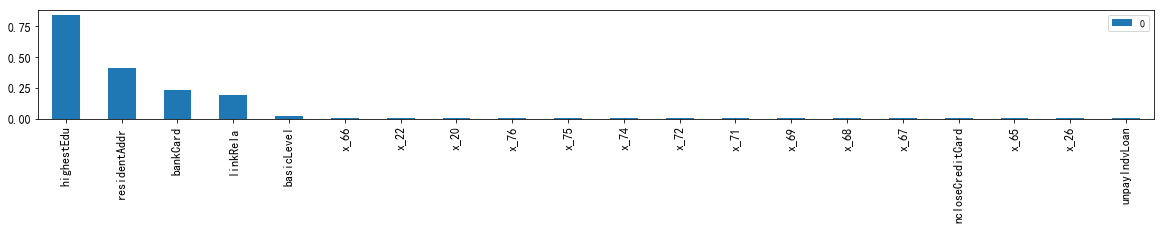

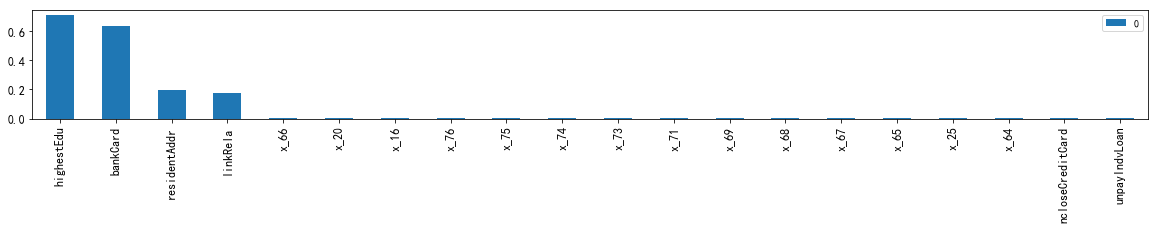

In [8]:
# 按列求-999的比例
train_col_nan_percent = (train_raw==-999).sum(axis=0) / train_raw.shape[0]
train_col_nan_percent = train_col_nan_percent.to_frame()
train_col_nan_percent.sort_values(by=0,ascending=False,inplace=True)
test_col_nan_percent = (test_raw==-999).sum(axis=0) / test_raw.shape[0]
test_col_nan_percent = test_col_nan_percent.to_frame()
test_col_nan_percent.sort_values(by=0,ascending=False,inplace=True)
# 列缺失值比例的柱状图，训练和测试集有差异
fu.plot_bar(train_col_nan_percent,by_col=0,num=20)
fu.plot_bar(test_col_nan_percent,by_col=0,num=20)

#### 0.2 按照行求缺失值数量  
- 原数据总共104个字段，最大缺失行87个缺失，即有17个是必填项目
- 删除34个字段，剩70个，最大缺失行53个，意料之中，因为删除的30个是重复的，17个必填

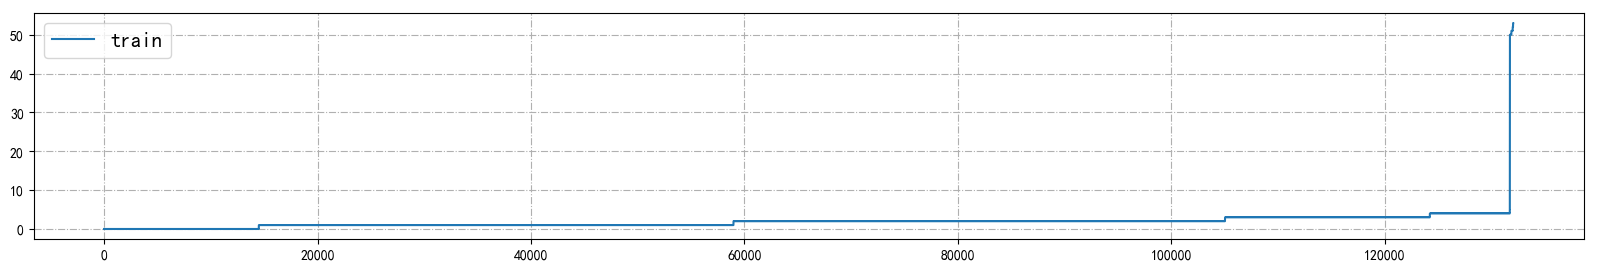

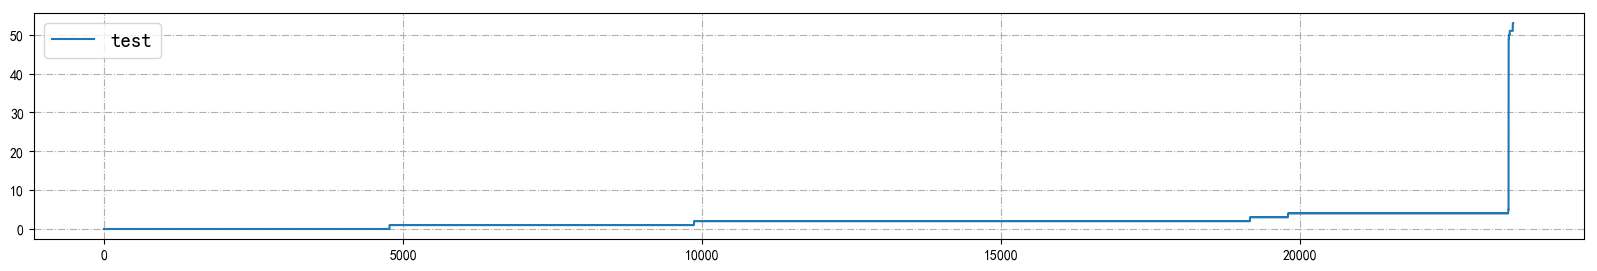

In [9]:
# 按列求-999的数量
train_raw_nan = (train_raw==-999).sum(axis=1).to_frame()
train_raw_nan.sort_values(by=0,ascending=True,inplace=True)
train_raw_nan.index = range(train_raw_nan.shape[0])
test_raw_nan = (test_raw==-999).sum(axis=1).to_frame()
test_raw_nan.sort_values(by=0,ascending=True,inplace=True)
test_raw_nan.index = range(test_raw_nan.shape[0])
# 升序后画折线图
fu.plot_line(train_raw_nan,columns_=[0],legend_=['train'],title_='')
fu.plot_line(test_raw_nan,columns_=[0],legend_=['test'],title_='')

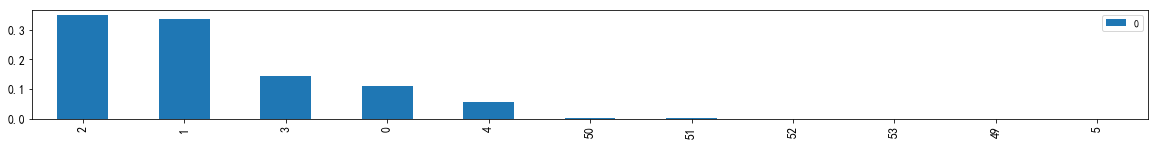

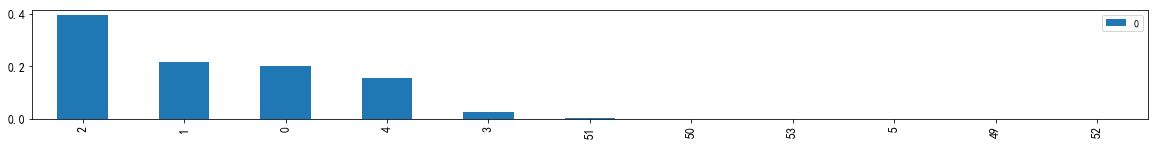

In [10]:
# 行缺失值比例的柱状图，训练和测试集有差异
train_raw_nan_percent = (train_raw_nan[0].value_counts()/train_raw.shape[0]).to_frame()
train_raw_nan_percent.sort_index(inplace=True)
test_raw_nan_percent = (test_raw_nan[0].value_counts()/test_raw_nan.shape[0]).to_frame()
test_raw_nan_percent.sort_index(inplace=True)
fu.plot_bar(train_raw_nan_percent,by_col=0,num=20)
fu.plot_bar(test_raw_nan_percent,by_col=0,num=20)

#### 0.3 按列对数值型变量求标准差  
- std小于0.1的可以提出，目前看来只有一个

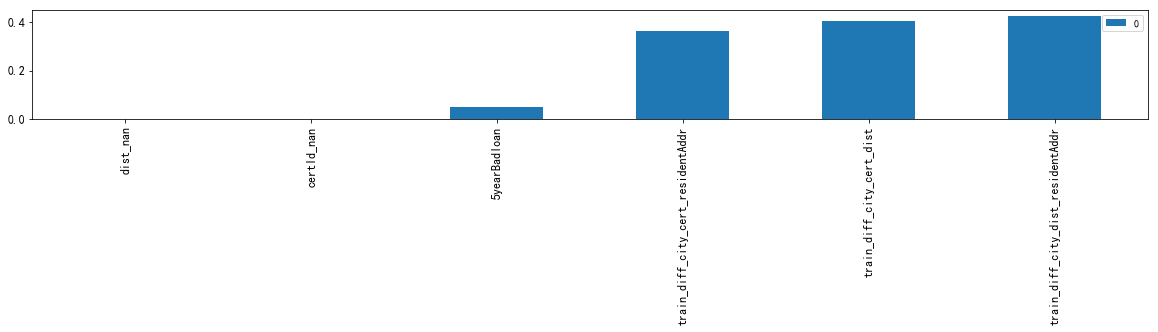

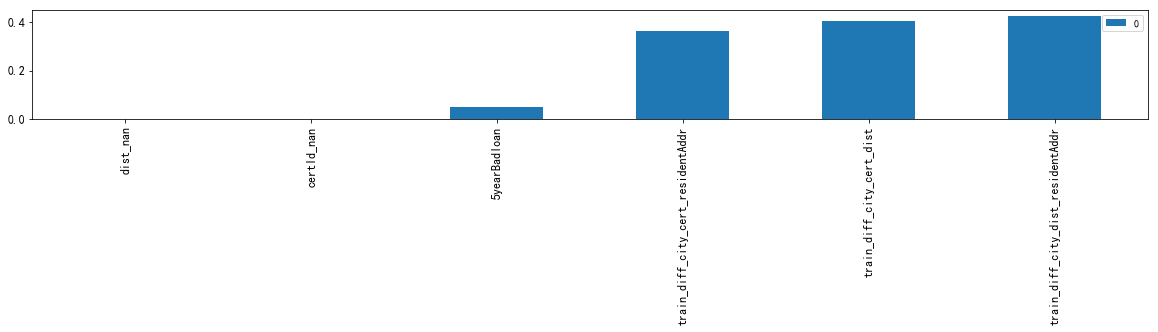

In [91]:
train_col_std = train_raw.std(axis=0).to_frame()
train_col_std.sort_values(by=0,inplace=True)
train_col_std = train_col_std.iloc[:20,:]
test_col_std = test_raw.std(axis=0).to_frame()
test_col_std.sort_values(by=0,inplace=True)
test_col_std = test_col_std.iloc[:20,:]
train_col_std = train_col_std.round(4)
test_col_std = test_col_std.round(4)
fu.plot_bar(train_col_std,by_col=0,num=6,ascending_=1)
fu.plot_bar(train_col_std,by_col=0,num=6,ascending_=1)

#### 0.4 通过xgb求出前20or40的特征，将这些特征缺失值大的样本剔除

In [12]:
# XGB Classifier
def XG_boost_classifier_CV(train_x, train_y):
    model = XGBClassifier(eval_metric='auc',
                          silent=1,
                          nthread=2,
                          scale_pos_weight=[1.4,2.1][1],#2.1, #***
                          n_estimators=[100,110][1],#110,
                          max_depth=3,  # 太大容易过拟合，6线下到0.98
                          learning_rate=0.1,
                          subsample=1,
                          colsample_bytree=1,
                          min_child_weight=1,
                          #early_stopping_rounds=1 # 默认值是
                         )
    # 训练前截取一个测试集，random_state把测试集固定了，应该更随机
    kfold_test = StratifiedShuffleSplit(n_splits=1,test_size=0.15,train_size=0.85,random_state=random.randint(0,1000))  # 对数据进行交叉验证划分
    for train,test in kfold_test.split(train_x, train_y):
        train_x_, train_y_ = train_x.iloc[train], train_y.iloc[train]    
    best_parameters = 1
    train_x_,train_y_ = train_x,train_y
    grid_search = model.fit(train_x_,train_y_)   # 执行类中的fit函数得到模型
    train_y_predprob = grid_search.predict_proba(train_x_)[:,1]
    train_auc = metrics.roc_auc_score(train_y_, train_y_predprob).round(4)                   # 计算auc    
    print('Training AUC:', train_auc)
    # 从训练集中截取一个子集作为样本内的test计算auc
    for train,test in kfold_test.split(train_x, train_y):
        y_predprob = grid_search.predict_proba(train_x.iloc[test])[:,1]
        test_auc = metrics.roc_auc_score(y_train.iloc[test], y_predprob).round(4)                   # 计算auc
        print('Testing AUC:', test_auc)    

    return grid_search,best_parameters,train_auc,test_auc

In [13]:
train_target_raw = pd.merge(train_raw,train_target, how='left', on=['id'])
column_use = list(test_raw.columns.values)
column_use = [x for x in column_use if x not in []]
X_train = train_raw[column_use].copy()
y_train = train_target_raw["target"].copy()
X_test = test_raw[column_use]

In [26]:
model,best_parameters,train_auc,test_auc = XG_boost_classifier_CV(X_train, y_train)

Training AUC: 0.7922
Testing AUC: 0.7887
Testing AUC: 0.8005
Testing AUC: 0.7883
Testing AUC: 0.7658
Testing AUC: 0.8331


In [27]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=110, n_jobs=1, nthread=2, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=2.1,
       seed=None, silent=1, subsample=1)

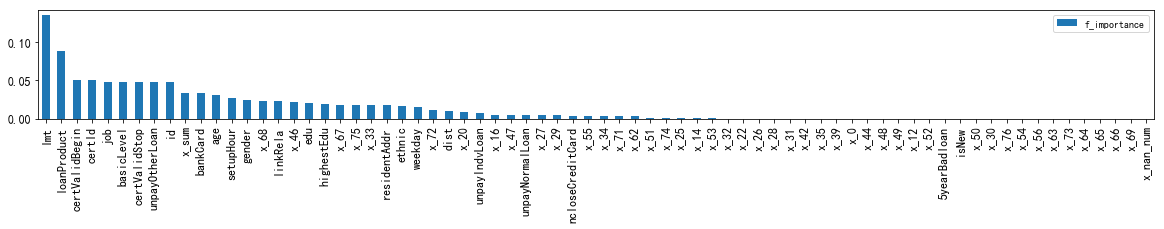

In [28]:
f_importance = pd.DataFrame()
f_importance['f_importance'] = model.feature_importances_
f_importance.index = X_train.columns
f_importance.sort_values(by='f_importance',ascending=False,inplace=True)
fu.plot_bar(f_importance,by_col='f_importance',num=80,)

In [29]:
# 0重要性的变量
_0_importance_col = f_importance[f_importance['f_importance']==0].index#.tolist()
high_importance_col = f_importance.iloc[:10].index

In [30]:
tp_train = train_raw[high_importance_col]
tp_test = test_raw[high_importance_col]

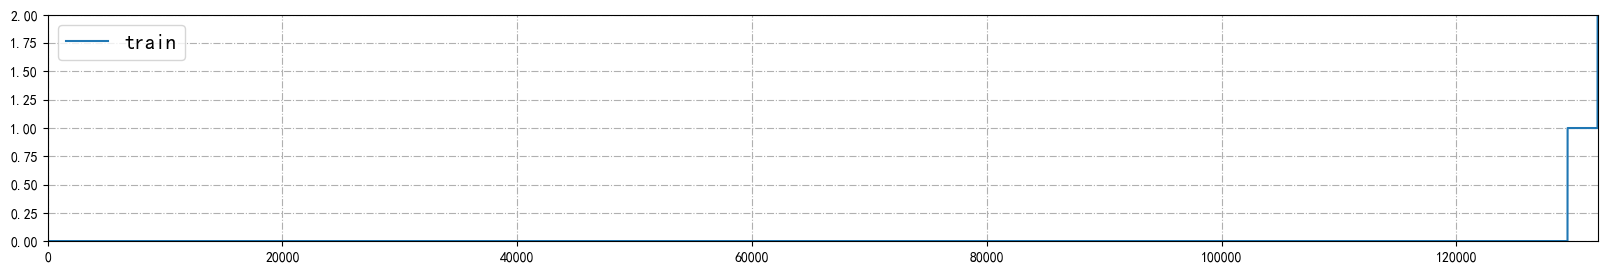

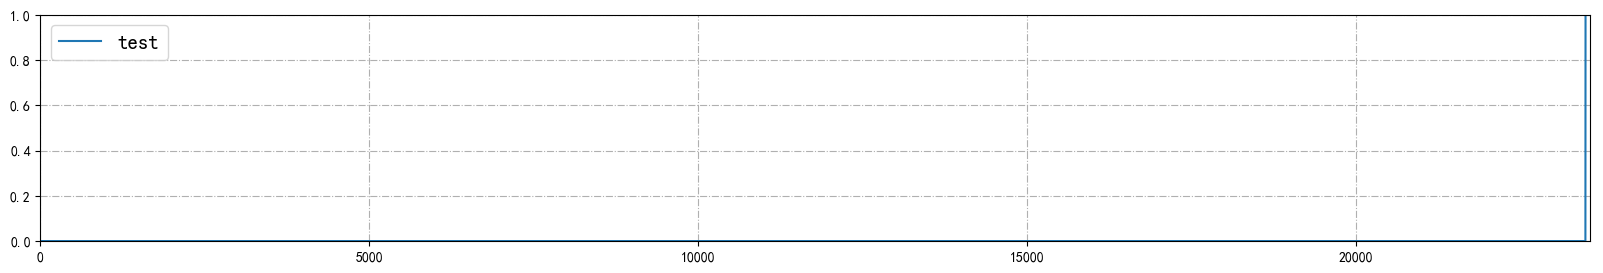

In [31]:
# 按列求-999的数量
train_raw_nan = (tp_train==-999).sum(axis=1).to_frame()
train_raw_nan.sort_values(by=0,ascending=True,inplace=True)
train_raw_nan.index = range(train_raw_nan.shape[0])
test_raw_nan = (tp_test==-999).sum(axis=1).to_frame()
test_raw_nan.sort_values(by=0,ascending=True,inplace=True)
test_raw_nan.index = range(test_raw_nan.shape[0])
# 升序后画折线图
fu.plot_line(train_raw_nan,columns_=[0],legend_=['train'],title_='')
fu.plot_line(test_raw_nan,columns_=[0],legend_=['test'],title_='')

# 1.特征工程

In [123]:
#user_inf
#loan_inf
#loan_history_inf
#x_inf

### 1.1证件、地区、居住地、民族
- 身份证：六位数字地址码，八位数字出生日期码，三位数字顺序码和一位数字校验码。中华人民共和国 居民身份证是国家法定的证明公民个人身份的有效证件。
    - 身份证一生都不会变，可以代表一个人的籍贯
    - 地区和居住地的区别又是什么
- 身份证前六位
    - 前两位是省:xx0000
    - 中间两位是市:xxyy00
    - 最后两位是区、县:从01开始排序，前20个是区，21以及之后是县，最后81+的是市下面的市
- 我国采用四级六位编码制，用6个阿拉伯数字组成，没有七位数的
    - 前两位表示省、市、自治区
    - 第三位代表邮区
    - 第四位代表县、市，代表投递邮局
    - 最后两位是代表从这个城市哪个投递区投递的，即投递区的位置

In [87]:
# 省的代码，前两位
train_raw['province'] = list(map(lambda x: x[:2],train_raw['certId'].astype(str).values))
test_raw['province'] = list(map(lambda x: x[:2],test_raw['certId'].astype(str).values))
train_raw['province'] = train_raw['province'].astype(int)
test_raw['province'] = test_raw['province'].astype(int)
# 市的代码，前四位
train_raw['city'] = list(map(lambda x: x[:4],train_raw['certId'].astype(str).values))
test_raw['city'] = list(map(lambda x: x[:4],test_raw['certId'].astype(str).values))
train_raw['city'] = train_raw['city'].astype(int)
test_raw['city'] = test_raw['city'].astype(int)

train_raw['dist_city'] = list(map(lambda x: x[:4],train_raw['dist'].astype(str).values))
test_raw['dist_city'] = list(map(lambda x: x[:4],test_raw['dist'].astype(str).values))
train_raw['dist_city'] = train_raw['dist_city'].astype(int)
test_raw['dist_city'] = test_raw['dist_city'].astype(int)

train_raw['residentAddr_city'] = list(map(lambda x: x[:4],train_raw['residentAddr'].astype(str).values))
test_raw['residentAddr_city'] = list(map(lambda x: x[:4],test_raw['residentAddr'].astype(str).values))
train_raw['residentAddr_city'] = train_raw['residentAddr_city'].astype(int)
test_raw['residentAddr_city'] = test_raw['residentAddr_city'].astype(int)

In [90]:
train_raw['train_diff_city_cert_dist'] = (train_raw['city']!=train_raw['dist_city'])
train_raw['train_diff_city_cert_residentAddr'] = (train_raw['city']!=train_raw['residentAddr_city'])
train_raw['train_diff_city_dist_residentAddr'] = (train_raw['dist_city']!=train_raw['residentAddr_city'])
train_raw['certId_nan'] = train_raw['certId'] == -999
train_raw['dist_nan'] = train_raw['certId'] == -999
train_raw['residentAddr_nan'] = train_raw['residentAddr'] == -999

test_raw['train_diff_city_cert_dist'] = (test_raw['city']!=test_raw['dist_city'])
test_raw['train_diff_city_cert_residentAddr'] = (test_raw['city']!=test_raw['residentAddr_city'])
test_raw['train_diff_city_dist_residentAddr'] = (test_raw['dist_city']!=test_raw['residentAddr_city'])
test_raw['certId_nan'] = test_raw['certId'] == -999
test_raw['dist_nan'] = test_raw['certId'] == -999
test_raw['residentAddr_nan'] = test_raw['residentAddr'] == -999

In [88]:
tp = train_raw[['city','dist_city','residentAddr_city']]

In [92]:
train_raw.head()

,id,gender,age,edu,highestEdu,ethnic,residentAddr,dist,job,certId,certValidBegin,certValidStop,bankCard,loanProduct,lmt,basicLevel,linkRela,setupHour,weekday,isNew,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,x_0,x_12,x_14,x_16,x_20,x_22,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_39,x_42,x_44,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_71,x_72,x_73,x_74,x_75,x_76,x_sum,x_nan_num,edu_bins,highestEdu_bins,province,city,dist_city,residentAddr_city,train_diff_city_cert_dist,train_diff_city_cert_residentAddr,train_diff_city_dist_residentAddr,certId_nan,dist_nan,residentAddr_nan
0,1,2,27,0,-999,0,640513,640500,8,640582,3637094400,3.952714e+09,-999.0,1,5.963,3,0,9,6,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,3,5,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,18,0,未知0,未知-999,64,6405,6405,6405,False,False,False,False,False,False
1,2,2,25,0,99,0,621023,640600,3,621023,3739996800,4.371149e+09,622848079.0,2,6.467,3,11,6,5,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,3,5,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,20,0,未知0,其他99,62,6210,6406,6210,True,False,True,False,False,False
2,3,2,37,70,70,0,641204,641200,5,641283,3347913600,3.979066e+09,-999.0,1,0.596,1,0,1,6,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,14,0,初中,初中,64,6412,6412,6412,False,False,False,False,False,False
3,4,2,29,0,-999,0,-999,340821,4,340821,3713385600,4.344538e+09,-999.0,3,6.300,3,-999,13,6,1,1,0,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0,3,4,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,22,0,未知0,未知-999,34,3408,3408,-999,False,True,True,False,False,True
4,5,2,22,0,99,4,732628,732628,2,732628,3652214400,3.967834e+09,622700392.0,2,6.700,2,11,8,3,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,16,0,未知0,其他99,73,7326,7326,7326,False,False,False,False,False,False


In [42]:
# 读取身份证代买与地区的对应关系
file_name = os.path.join(data_path,'身份证号前6位地区代码.csv')
with open(file_name,'r',encoding='utf-8') as f:
    certid_position = pd.read_csv(f)
certid_position.columns = ['certid_position_numb','position']
certid_position['province'] = list(map(lambda x: x[:2],certid_position['certid_position_numb'].astype(str).values))
certid_position['city'] = list(map(lambda x: x[:4],certid_position['certid_position_numb'].astype(str).values))
certid_position = certid_position.iloc[:certid_position.shape[0]-3,:]
certid_position.head()

,certid_position_numb,position,province,city
0,110000,北京市,11,1100
1,110100,北京市市辖区,11,1101
2,110101,北京市东城区,11,1101
3,110102,北京市西城区,11,1101
4,110105,北京市朝阳区,11,1101


In [43]:
province_df = certid_position.groupby(by='province').apply(lambda x:x.iloc[0,:])
province_df['position'] = list(map(lambda x:x[:2],province_df['position'].astype(str).values))
province_df = province_df.sort_values(by='province')

city_df = certid_position.groupby(by='city').apply(lambda x:x.iloc[0,:])
city_df['position'] = list(map(lambda x:x[:6],city_df['position'].astype(str).values))
city_df = city_df.sort_values(by='city')

In [39]:
# 省的代码
train_raw['province'] = list(map(lambda x: x[:2],train_raw['certId'].astype(str).values))
test_raw['province'] = list(map(lambda x: x[:2],test_raw['certId'].astype(str).values))
train_target_raw = pd.merge(train_raw,train_target, how='left', on=['id'])
tp = train_target_raw[['province','target','certId']]
tp = tp.sort_values(by='province')
tp_ = tp.groupby('province').mean()
tp_['count'] = tp.groupby('province').count()['target']
tp_ = pd.merge(tp_,province_df,on='province',how='left')
tp_.head()

,province,target,certId,count,certid_position_numb,position,city
0,31,0.001305,310148.502611,766,310000,上海,310000
1,32,0.003630,320144.094374,551,320100,江苏,320100
2,33,0.004525,330727.233937,4420,330100,浙江,330100
3,34,0.011232,341583.632152,2849,340100,安徽,340100
4,35,0.009165,351542.644603,1964,350100,福建,350100


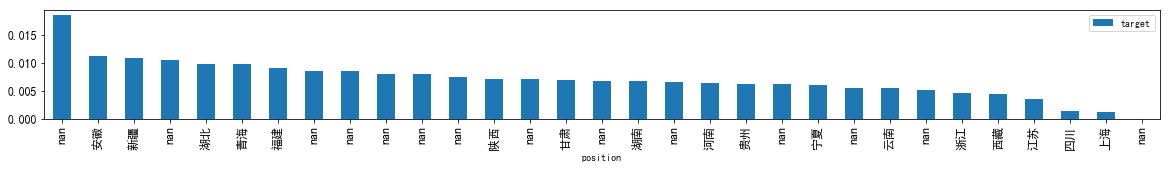

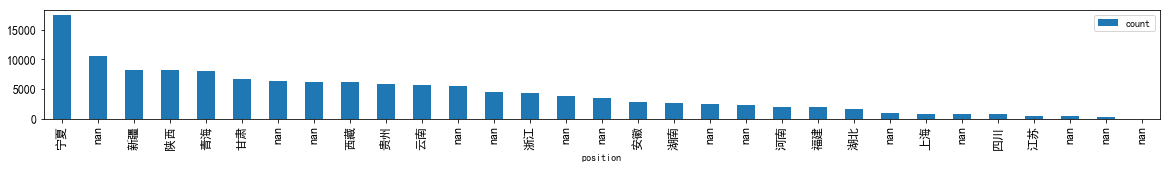

In [40]:
tp_.index = tp_['position']
fu.plot_bar(tp_[['position','target']],by_col='target',num=34,ascending_=0)
fu.plot_bar(tp_[['position','count']],by_col='count',num=34,ascending_=0)

In [44]:
# 市的代码
train_raw['city'] = list(map(lambda x: x[:4],train_raw['certId'].astype(str).values))
test_raw['city'] = list(map(lambda x: x[:4],test_raw['certId'].astype(str).values))
train_target_raw = pd.merge(train_raw,train_target, how='left', on=['id'])
tp = train_target_raw[['city','target','certId']]
tp = tp.sort_values(by='city')
tp_ = tp.groupby('city').mean()
tp_['count'] = tp.groupby('city').count()['target']
tp_ = pd.merge(tp_,city_df,on='city',how='left')
tp_.head()

,city,target,certId,count,certid_position_numb,position,province
0,3101,0.002041,310105.671429,490,310100,上海市市辖区,31
1,3102,0.000000,310224.543478,276,310200,上海市县,31
2,3201,0.002688,320106.002688,372,320100,江苏省南京市,32
3,3202,0.005587,320223.256983,179,320200,江苏省无锡市,32
4,3301,0.001582,330137.955696,632,330100,浙江省杭州市,33


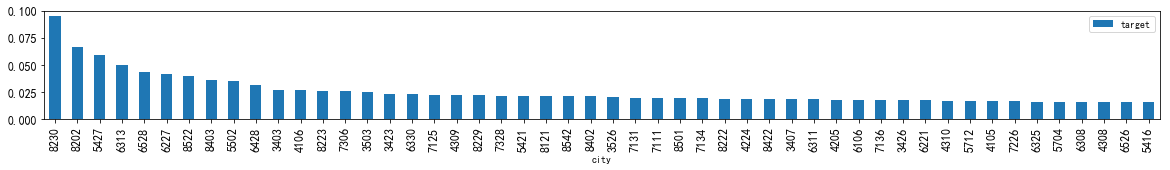

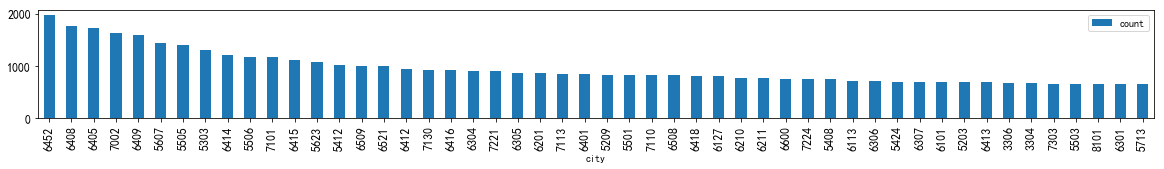

In [67]:
tp_.index = tp_['city']
fu.plot_bar(tp_[['position','target']],by_col='target',num=50,ascending_=0)
fu.plot_bar(tp_[['position','count']],by_col='count',num=50,ascending_=0)

In [18]:
# 省的代码test
test_raw['province'] = list(map(lambda x: x[:2],test_raw['certId'].astype(str).values))
test_raw['province'] = list(map(lambda x: x[:2],test_raw['certId'].astype(str).values))
tp = test_raw[['province','certId']]
tp = tp.sort_values(by='province')
tp_ = tp.groupby('province').mean()
tp_['count'] = tp.groupby('province').count()['certId']
tp_ = pd.merge(tp_,province_df,on='province',how='left')
tp_.index = tp_['position']
fu.plot_bar(tp_[['position','count']],by_col='count',num=34,ascending_=0)

### 通过xgb测试city的one_hot

In [61]:
one_hot_city_train = pd.get_dummies(train_raw[['city']].astype(str))
one_hot_city_train = pd.concat([train_target_raw['target'],one_hot_city_train],axis=1)
column_use = list(one_hot_city_train.columns.values)
column_use = [x for x in column_use if x not in ['target']]
X_train = one_hot_city_train[column_use].copy()
y_train = one_hot_city_train["target"].copy()
#X_test = test_raw[column_use]
model,best_parameters,train_auc,test_auc = XG_boost_classifier_CV(X_train, y_train)

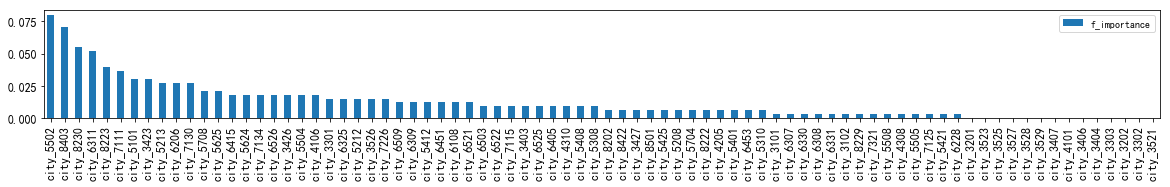

In [63]:
f_importance = pd.DataFrame()
f_importance['f_importance'] = model.feature_importances_
f_importance.index = X_train.columns
f_importance.sort_values(by='f_importance',ascending=False,inplace=True)
fu.plot_bar(f_importance,by_col='f_importance',num=80,)

In [70]:
# 0重要性的变量
_0_importance_col = f_importance[f_importance['f_importance']==0].index#.tolist()
high_importance_col = f_importance.iloc[:40].index
print('high_importance_col:',high_importance_col)

high_importance_col: Index(['city_5502', 'city_8403', 'city_8230', 'city_6311', 'city_8223',
       'city_7111', 'city_5101', 'city_3423', 'city_5213', 'city_6206',
       'city_7130', 'city_5708', 'city_5625', 'city_6415', 'city_5624',
       'city_7134', 'city_6526', 'city_3426', 'city_5504', 'city_4106',
       'city_3301', 'city_6325', 'city_5212', 'city_3526', 'city_7226',
       'city_6509', 'city_6309', 'city_5412', 'city_6451', 'city_6108',
       'city_6521', 'city_6503', 'city_6522', 'city_7115', 'city_3403',
       'city_6525', 'city_6405', 'city_4310', 'city_5408', 'city_5308'],
      dtype='object')


In [71]:
one_hot_province_train = pd.get_dummies(train_raw[['province']].astype(str))
one_hot_province_train = pd.concat([train_target_raw['target'],one_hot_province_train],axis=1)
column_use = list(one_hot_province_train.columns.values)
column_use = [x for x in column_use if x not in ['target']]
X_train = one_hot_province_train[column_use].copy()
y_train = one_hot_province_train["target"].copy()
#X_test = test_raw[column_use]
model,best_parameters,train_auc,test_auc = XG_boost_classifier_CV(X_train, y_train)

Training AUC: 0.5774
Testing AUC: 0.5927


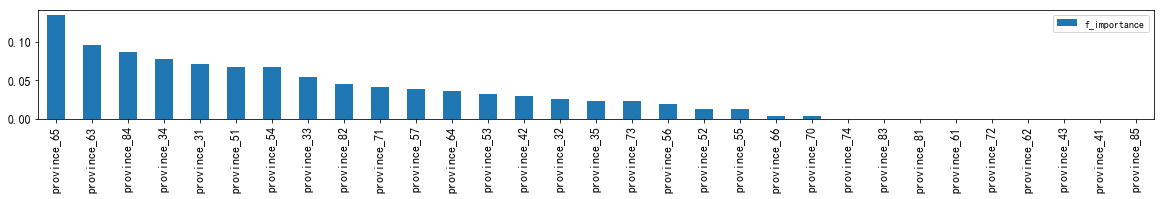

In [72]:
f_importance = pd.DataFrame()
f_importance['f_importance'] = model.feature_importances_
f_importance.index = X_train.columns
f_importance.sort_values(by='f_importance',ascending=False,inplace=True)
fu.plot_bar(f_importance,by_col='f_importance',num=80,)

In [73]:
# 0重要性的变量
_0_importance_col = f_importance[f_importance['f_importance']==0].index#.tolist()
high_importance_col = f_importance.iloc[:40].index
print('high_importance_col:',high_importance_col)

high_importance_col: Index(['province_65', 'province_63', 'province_84', 'province_34',
       'province_31', 'province_51', 'province_54', 'province_33',
       'province_82', 'province_71', 'province_57', 'province_64',
       'province_53', 'province_42', 'province_32', 'province_35',
       'province_73', 'province_56', 'province_52', 'province_55',
       'province_66', 'province_70', 'province_74', 'province_83',
       'province_81', 'province_61', 'province_72', 'province_62',
       'province_43', 'province_41', 'province_85'],
      dtype='object')


In [19]:
tp = train_raw[['certId','dist','residentAddr','ethnic']]
tp.sort_values(by='dist',inplace=True)
tp.index = range(tp.shape[0])

tp_test = test_raw[['certId','dist','residentAddr','ethnic']]
tp_test.sort_values(by='dist',inplace=True)
tp_test.index = range(tp_test.shape[0])
#tist = tp.hist(bins=500,figsize=(20,10))

In [20]:
print('train')
print(f'certId的unique个数{len(set(tp["certId"].tolist()))}')
print(f'dist的unique个数{len(set(tp["dist"].tolist()))}')
print(f'residentAddr的unique个数{len(set(tp["residentAddr"].tolist()))}')
print(f'ethnic的unique个数{len(set(tp["ethnic"].tolist()))}')
print('test')
print(f'certId的unique个数{len(set(tp_test["certId"].tolist()))}')
print(f'dist的unique个数{len(set(tp_test["dist"].tolist()))}')
print(f'residentAddr的unique个数{len(set(tp_test["residentAddr"].tolist()))}')
print(f'ethnic的unique个数{len(set(tp_test["ethnic"].tolist()))}')

train
certId的unique个数4033
dist的unique个数3738
residentAddr的unique个数5288
ethnic的unique个数49
test
certId的unique个数3328
dist的unique个数2629
residentAddr的unique个数2515
ethnic的unique个数37


In [21]:
# train_raw.drop(index=train_raw[train_raw['dist']>900000].index,inplace=True)
# test_raw.drop(index=test_raw[test_raw['dist']>900000].index,inplace=True)
# train_raw.drop(index=train_raw[train_raw['residentAddr']>900000].index,inplace=True)
# test_raw.drop(index=test_raw[test_raw['residentAddr']>900000].index,inplace=True)

In [ ]:
col_ = 'residentAddr'
tp.sort_values(by=col_,inplace=True)
#tp.iloc[60000:60100:]

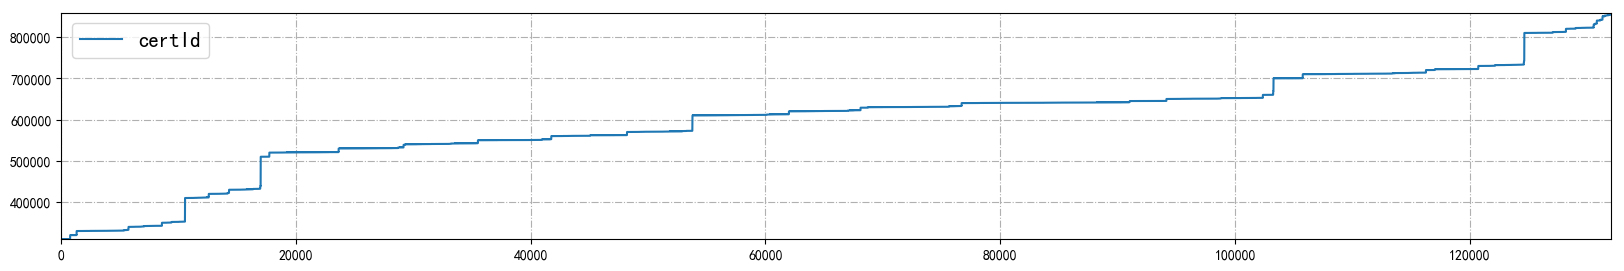

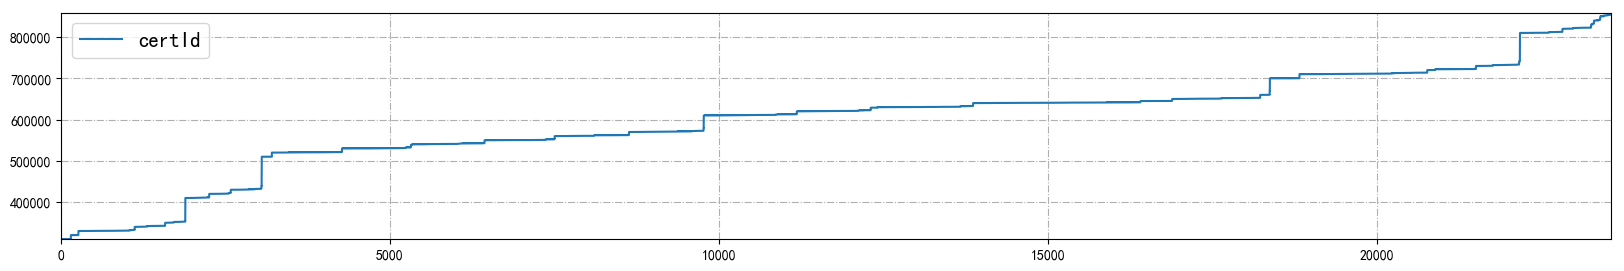

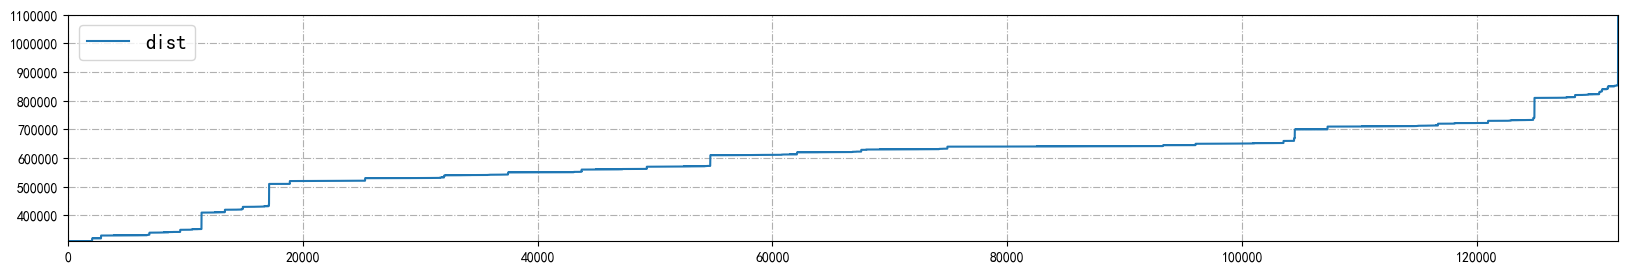

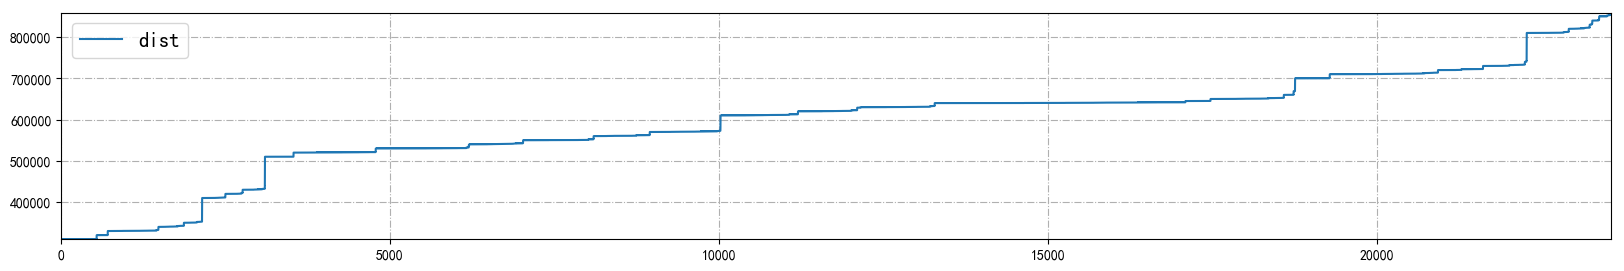

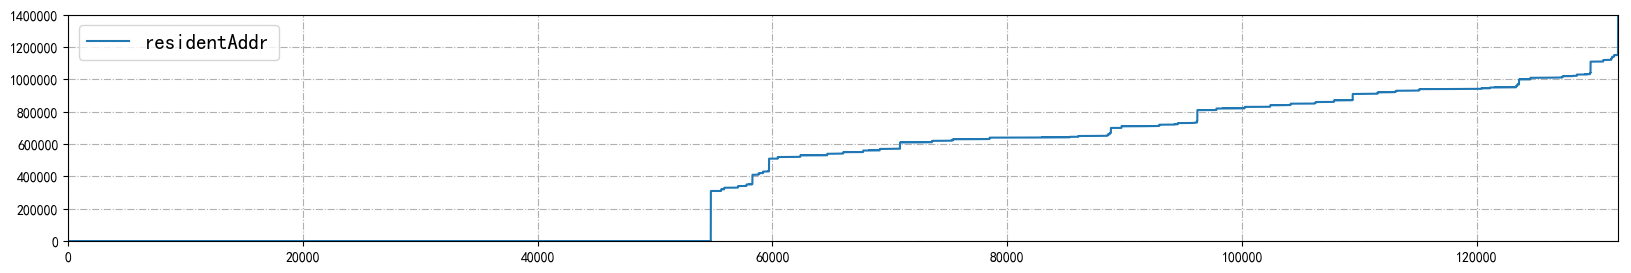

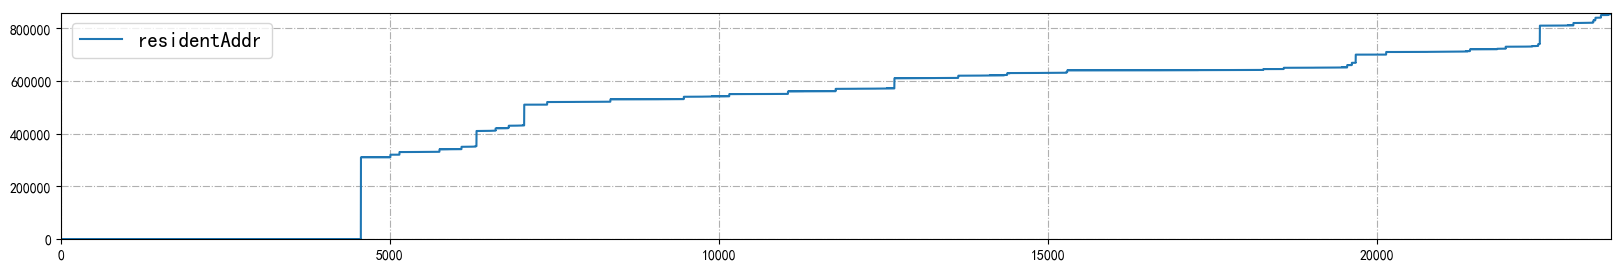

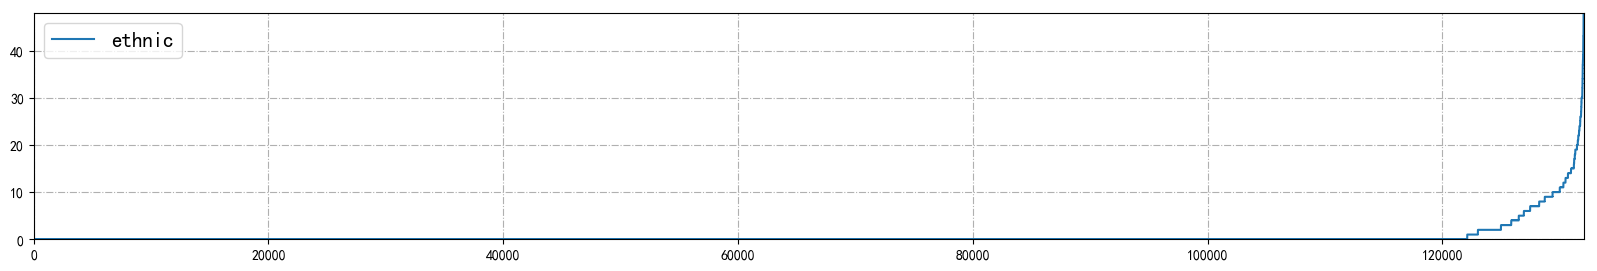

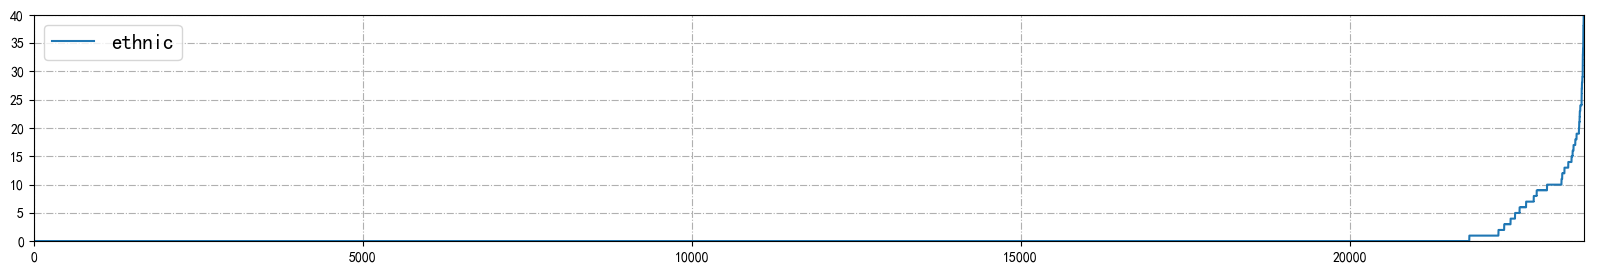

In [106]:
col_ = 'certId'
tp.sort_values(by=col_,inplace=True)
tp_test.sort_values(by=col_,inplace=True)
fu.plot_line(tp,columns_=[col_],legend_=[col_],title_='')
fu.plot_line(tp_test,columns_=[col_],legend_=[col_],title_='')
col_ = 'dist'
tp.sort_values(by=col_,inplace=True)
tp_test.sort_values(by=col_,inplace=True)
fu.plot_line(tp,columns_=[col_],legend_=[col_],title_='')
fu.plot_line(tp_test,columns_=[col_],legend_=[col_],title_='')
col_ = 'residentAddr'
tp.sort_values(by=col_,inplace=True)
tp_test.sort_values(by=col_,inplace=True)
fu.plot_line(tp,columns_=[col_],legend_=[col_],title_='')
fu.plot_line(tp_test,columns_=[col_],legend_=[col_],title_='')
col_ = 'ethnic'
tp.sort_values(by=col_,inplace=True)
tp_test.sort_values(by=col_,inplace=True)
fu.plot_line(tp,columns_=[col_],legend_=[col_],title_='')
fu.plot_line(tp_test,columns_=[col_],legend_=[col_],title_='')

### 教育

In [ ]:
train_raw['edu_is_0'] = train_raw['edu']==0
train_raw['edu_is_30'] = train_raw['edu']==30
train_raw['edu_is_70'] = train_raw['edu']==70
train_raw['highestEdu_is_30'] = train_raw['highestEdu']==30
train_raw['highestEdu_is_40'] = train_raw['highestEdu']==40
train_raw['highestEdu_is_70'] = train_raw['highestEdu']==70

test_raw['edu_is_0'] = test_raw['edu']==0
test_raw['edu_is_30'] = test_raw['edu']==30
test_raw['edu_is_70'] = test_raw['edu']==70
test_raw['highestEdu_is_30'] = test_raw['highestEdu']==30
test_raw['highestEdu_is_40'] = test_raw['highestEdu']==40
test_raw['highestEdu_is_70'] = test_raw['highestEdu']==70

In [14]:
edu_code = pd.read_csv(os.path.join(data_path,'学历代码.csv'),engine='python',encoding='gbk',header=0)

In [15]:
edu_code

,代码,学历
0,10,研究生教育
1,20,大学本科
2,30,专科教育
3,40,中等职业教育
4,50,高中以下
5,60,普通高级中学教育
6,70,初级中学教育
7,80,小学教育
8,90,其他
9,99,其他


In [57]:
train_raw['edu_bins'] = pd.cut(train_raw['edu'],bins=[-1000,-1,1,11,21,41,51,61,71,81,100],labels=['未知-999','未知0','研究生','大学生','中高专','高中以下','高中','初中','小学','其他99'])
train_raw['highestEdu_bins'] = pd.cut(train_raw['highestEdu'],bins=[-1000,-1,1,11,21,41,51,61,71,81,100],labels=['未知-999','未知0','研究生','大学生','中高专','高中以下','高中','初中','小学','其他99'])

In [82]:
tp = train_target_raw[['edu_bins','highestEdu_bins','target']].groupby(['highestEdu_bins']).mean()
tp.dropna()

,target
highestEdu_bins,
未知-999,0.007532
研究生,0.000000
大学生,0.006944
中高专,0.014276
高中以下,0.000000
高中,0.000000
初中,0.014925
其他99,0.004991


In [83]:
tp = train_target_raw[['edu','highestEdu','target']].groupby(['highestEdu']).mean()
tp.dropna()

,edu,target
highestEdu,,
-999,0.212030,0.007532
10,4.827586,0.000000
20,9.236111,0.006944
30,14.689349,0.016272
40,19.144509,0.012717
50,47.000000,0.000000
60,45.000000,0.000000
70,32.388060,0.014925
99,0.327609,0.004991


In [42]:
print(train_target_raw['highestEdu'].unique().tolist())
print(train_target_raw['edu'].unique().tolist())
print(test_raw['highestEdu'].unique().tolist())
print(test_raw['edu'].unique().tolist())

[-999, 99, 70, 40, 30, 20, 10, 60, 50]
[0, 70, 30, 40, 20, 10, 60, -999, 47]
[-999, 30, 99, 70, 20, 40, 60, 10]
[0, 30, 20, 40, 70, 60, 10, -999, 47]


In [16]:
# print(train_target_raw['edu'].value_counts())
# print(test_raw['edu'].value_counts())
# print(train_target_raw['highestEdu'].value_counts())
# print(test_raw['highestEdu'].value_counts())

In [18]:
tp = train_target_raw[['edu','highestEdu','target']]

In [20]:
tp.sort_values('edu',inplace=True)

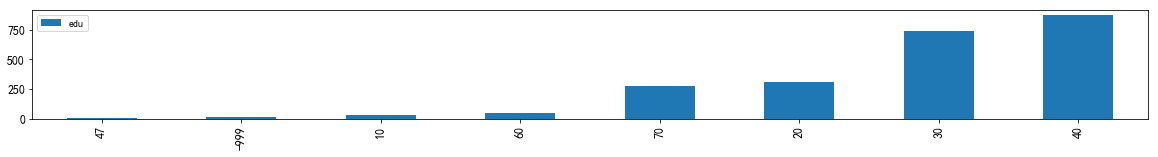

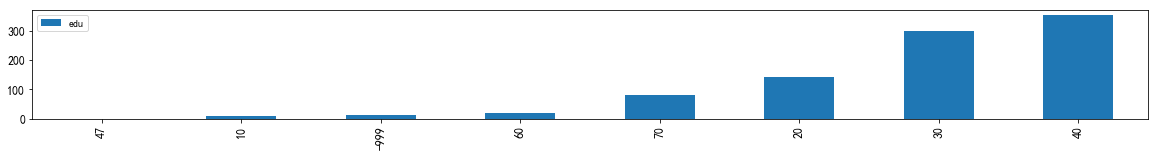

In [125]:
tp = train_target_raw['edu'].value_counts().to_frame()
fu.plot_bar(tp,'edu',8,1)
tp = test_raw['edu'].value_counts().to_frame()
fu.plot_bar(tp,'edu',8,1)

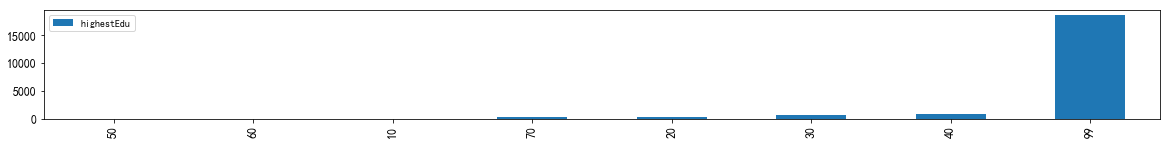

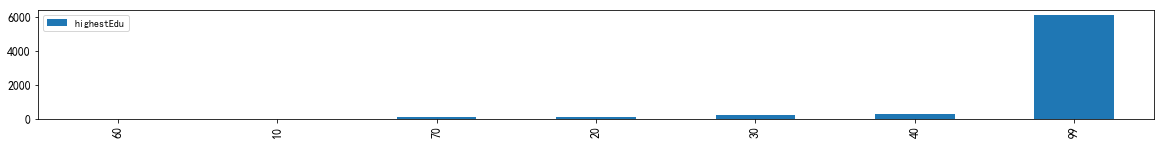

In [129]:
tp = train_target_raw['highestEdu'].value_counts().to_frame()
fu.plot_bar(tp,'highestEdu',8,1)
tp = test_raw['highestEdu'].value_counts().to_frame()
fu.plot_bar(tp,'highestEdu',7,1)

In [14]:
train_raw.loc[:,'edu'][train_raw.loc[:,'edu']==0] = np.nan
train_raw.loc[:,'highestEdu'][train_raw.loc[:,'highestEdu']==99] = np.nan
test_raw.loc[:,'edu'][train_raw.loc[:,'edu']==0] = np.nan
test_raw.loc[:,'highestEdu'][train_raw.loc[:,'highestEdu']==99] = np.nan

### 证件、地区、居住地、银行卡

身份证：六位数字地址码，八位数字出生日期码，三位数字顺序码和一位数字校验码。中华人民共和国 居民身份证是国家法定的证明公民个人身份的有效证件。 

In [ ]:
tp = train_raw[['certId','dist','residentAddr','bankCard']]
# tp['d_cd'] = tp['certId'] - tp['dist']
# tp['d_cr'] = tp['certId'] - tp['residentAddr']
# tp['d_dr'] = tp['dist'] - tp['residentAddr']
# tp['d_cr_'] = (tp['d_cr'] == 0).astype(int)
# tp.loc[:,'d_cr_'][tp.loc[:,'d_cr_']==300000] = 2
#tp[pd.isnull(tp)]=0
#tp[tp==0]=np.nan
#tp[tp==99]=np.nan
tp.sort_values(by='dist',inplace=True)
tp.index = range(tp.shape[0])
#tist = tp.hist(bins=500,figsize=(20,10))

In [4]:
print(f'bankCard的unique个数{len(set(tp["bankCard"].tolist()))}')

bankCard的unique个数26143


In [310]:
print(f'certId的unique个数{len(set(tp["certId"].tolist()))}')
print(f'dist的unique个数{len(set(tp["dist"].tolist()))}')
print(f'residentAddr的unique个数{len(set(tp["residentAddr"].tolist()))}')

certId的unique个数4033
dist的unique个数3738
residentAddr的unique个数60030


In [147]:
print(f'd_cd的unique个数{len(set(tp["d_cd"].tolist()))}')
print(f'd_cr的unique个数{len(set(tp["d_cr"].tolist()))}')
print(f'd_dr的unique个数{len(set(tp["d_dr"].tolist()))}')

d_cd的unique个数9023
d_cr的unique个数69268
d_dr的unique个数60232


In [16]:
train_raw['d_cd'] = (tp['d_cd'] == 0).astype(int)
train_raw['d_cr'] = tp['d_cr_']

In [17]:
tp = test_raw[['certId','dist','residentAddr']]
tp['d_cd'] = tp['certId'] - tp['dist']
tp['d_cr'] = tp['certId'] - tp['residentAddr']
tp['d_dr'] = tp['dist'] - tp['residentAddr']
tp['d_cr_'] = (tp['d_cr'] == 0).astype(int)
tp.loc[:,'d_cr_'][tp.loc[:,'d_cr_']==300000] = 2

test_raw['d_cd'] = (tp['d_cd'] == 0).astype(int)
test_raw['d_cr'] = tp['d_cr_']

In [18]:
train_raw.drop(['certId','dist','residentAddr'],axis=1,inplace=True)
test_raw.drop(['certId','dist','residentAddr'],axis=1,inplace=True)

### 证件时间

1、16岁以下的，发给有效期为5年的居民身份证；

2、16周岁至25周岁的，发给有效期为10年的居民身份证；

3、26周岁至45周岁的，发给有效期为20年的居民身份证；

4、46周岁以上的，发给长期有效的居民身份证。证件有效期限从签发之日起计算。

#### 公民身份号码是特征组合码，由十七位数字本体码和一位数字校验码组成。  
排列顺序从左至右依次为：
1. 六位数字地址码(地区行政代码)  
- 八位数字出生日期码  
- 三位数字顺序码和  
    1. 表示在同一地址码所标识的区域范围内，对同年、同月、同日出生的人编定的顺序号
    2. 顺序码的奇数分配给男性，偶数分配给女性。
- 一位数字校验码

In [ ]:
#time.gmtime(train_raw['certValidStop'][15]-train_raw['certValidBegin'][15])
tp = train_raw[['certValidBegin','certValidStop','age']]
tp['d_certv'] = tp['certValidStop'] - tp['certValidBegin']
tp['begin_year'] = np.array([time.gmtime(i).tm_year for i in tp['certValidBegin'].tolist()]).astype(float)
tp_list = []
for i in tp['certValidStop'].tolist():
    try:
        tp_ = time.gmtime(i).tm_year
        tp_list.append(tp_)
    except:
        tp_list.append(np.nan)
tp['stop_year'] = np.array(tp_list).astype(float)
#tp['stop_year'] = [time.gmtime(i) for i in tp['certValidStop'].tolist()]
tp['cert_gap'] = tp['stop_year'] - tp['begin_year']
tp[tp > 25000000000000] = np.nan
tp.sort_values(by='certValidBegin',inplace=True)
tp.index = range(tp.shape[0])
#tist = tp.hist(bins=500,figsize=(20,10))

In [26]:
train_raw['begin_year'] = tp['begin_year']
train_raw['stop_year'] = tp['stop_year']
train_raw['cert_gap'] = tp['cert_gap']

In [ ]:
tp = test_raw[['certValidBegin','certValidStop','age']]
tp['d_certv'] = tp['certValidStop'] - tp['certValidBegin']
tp['begin_year'] = np.array([time.gmtime(i).tm_year for i in tp['certValidBegin'].tolist()]).astype(float)
tp_list = []
for i in tp['certValidStop'].tolist():
    try:
        tp_ = time.gmtime(i).tm_year
        tp_list.append(tp_)
    except:
        tp_list.append(np.nan)
tp['stop_year'] = np.array(tp_list).astype(float)
#tp['stop_year'] = [time.gmtime(i) for i in tp['certValidStop'].tolist()]
tp['cert_gap'] = tp['stop_year'] - tp['begin_year']

test_raw['begin_year'] = tp['begin_year']
test_raw['stop_year'] = tp['stop_year']
test_raw['cert_gap'] = tp['cert_gap']

In [22]:
train_raw.drop(['certValidBegin','certValidStop'],axis=1,inplace=True)
test_raw.drop(['certValidBegin','certValidStop',],axis=1,inplace=True)

### Job  
test的job没有11,13,16  
train没有9,14
进行one-hot

In [136]:
train_raw = pd.concat([train_raw,pd.get_dummies(train_raw[['job']].astype(str))],axis=1)
train_raw.drop(columns=['job'],inplace=True)
test_raw = pd.concat([test_raw,pd.get_dummies(test_raw[['job']].astype(str))],axis=1)
test_raw.drop(columns=['job'],inplace=True)

In [137]:
train_raw['job_9'] = 0
train_raw['job_14'] = 0
test_raw['job_11'] = 0
test_raw['job_13'] = 0
test_raw['job_16'] = 0

train_raw.drop(columns=['job_11','job_13','job_16'],inplace=True)
test_raw.drop(columns=['job_9','job_14'],inplace=True)

### 授信金额、产品类型、基础评级、未偿还个人贷款、是否有还在使用的信用卡、未偿还的正常贷款、5年的坏账、其他为偿还贷款  
- unpayOtherLoan:
- lmt,loanProduct是原始数据得分最高的特征
    - loanProduct分为1,2,3,每一层target=1的lmt均值都与当层有差别

In [28]:
#test_raw.loc[:,'unpayOtherLoan'][pd.isnull(test_raw['unpayOtherLoan'])==1] = -999
# 信用变量有几个是1
train_raw['loan_sum'] = (train_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']]==1).sum(axis=1)
test_raw['loan_sum'] = (test_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']]==1).sum(axis=1)
# 信用变量变量有几个是nan(-999)
train_raw['loan_nan_num'] = np.array((train_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']]<0).sum(axis=1)) + np.array((pd.isnull(train_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']])==1).sum(axis=1))
test_raw['loan_nan_num'] = np.array((test_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']]<0).sum(axis=1)) + np.array((pd.isnull(test_raw[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan']])==1).sum(axis=1))

In [33]:
tmp[['unpayIndvLoan','unpayNormalLoan', '5yearBadloan','unpayOtherLoan',]].sum()

unpayIndvLoan       18456.0
unpayNormalLoan     20113.0
5yearBadloan          312.0
unpayOtherLoan     114907.0
dtype: float64

In [46]:
tmp.sort_values(by=['target','loan_num','basicLevel','loanProduct','lmt'],ascending=False,inplace=True)
tmp.head()

,target,lmt,loanProduct,basicLevel,unpayIndvLoan,ncloseCreditCard,unpayNormalLoan,5yearBadloan,unpayOtherLoan,loan_num
25936,1,4.733,2,3.0,1.0,1.0,1.0,0,1.0,3.0
25853,1,6.467,2,1.0,1.0,1.0,1.0,0,1.0,3.0
94606,1,14.963,1,1.0,1.0,1.0,1.0,0,1.0,3.0
94622,1,10.630,1,1.0,1.0,1.0,1.0,0,1.0,3.0
94623,1,10.296,1,1.0,1.0,1.0,1.0,0,1.0,3.0


In [273]:
#tmp['lmt_lp'] = tmp['lmt'] / tmp['loanProduct']
#tmp['lmt_x_lp'] = tmp['lmt']**4 * tmp['loanProduct']
tmp = pd.concat([tmp,pd.get_dummies(tmp[['loanProduct']].astype(str))],axis=1)
tmp.drop(['loanProduct'],axis=1,inplace=True)
tmp.loc[:,'unpayOtherLoan'][tmp.loc[:,'unpayOtherLoan']<0] = 2
tmp = pd.concat([tmp,pd.get_dummies(tmp[['unpayOtherLoan']].astype(str))],axis=1)
tmp.drop(['unpayOtherLoan'],axis=1,inplace=True)

In [288]:
print(tmp.mean()['target'].round(4)*100)
print(tmp[tmp['loanProduct']==1].mean()['target'].round(4)*100)
print(tmp[tmp['loanProduct']==2].mean()['target'].round(4)*100)
print(tmp[tmp['loanProduct']==3].mean()['target'].round(4)*100)

0.73
1.22
0.5700000000000001
0.44


In [311]:
print(tmp[tmp['loanProduct']==1].mean()['lmt'].round(4))
print(tmp[tmp['loanProduct']==2].mean()['lmt'].round(4))
print(tmp[tmp['loanProduct']==3].mean()['lmt'].round(4))

7.1562
5.5715
5.5031


In [312]:
print(tmp[tmp['loanProduct']==1][tmp['target']==1].mean()['lmt'].round(4))
print(tmp[tmp['loanProduct']==2][tmp['target']==1].mean()['lmt'].round(4))
print(tmp[tmp['loanProduct']==3][tmp['target']==1].mean()['lmt'].round(4))

4.1444
4.4765
3.2631


In [352]:
#plot_line(tmp,columns_=['unpayOtherLoan'],legend_=['target','lmt','loanProduct'],title_='')

In [353]:
#plot_line(tmp,columns_=['lmt'],legend_=['target','lmt','loanProduct'],title_='')

In [5]:
train_raw = pd.concat([train_raw,pd.get_dummies(train_raw[['loanProduct']].astype(str))],axis=1)
train_raw.drop(['loanProduct'],axis=1,inplace=True)
train_raw.loc[:,'unpayOtherLoan'][train_raw.loc[:,'unpayOtherLoan']<0] = np.nan
train_raw = pd.concat([train_raw,pd.get_dummies(train_raw[['unpayOtherLoan']].astype(str))],axis=1)
train_raw.drop(['unpayOtherLoan'],axis=1,inplace=True)

test_raw = pd.concat([test_raw,pd.get_dummies(test_raw[['loanProduct']].astype(str))],axis=1)
test_raw.drop(['loanProduct'],axis=1,inplace=True)
test_raw.loc[:,'unpayOtherLoan'][test_raw.loc[:,'unpayOtherLoan']<0] = np.nan
test_raw = pd.concat([test_raw,pd.get_dummies(test_raw[['unpayOtherLoan']].astype(str))],axis=1)
test_raw.drop(['unpayOtherLoan'],axis=1,inplace=True)

In [6]:
test_raw.shape

(23561, 108)

In [7]:
train_raw.shape

(132029, 109)

In [ ]:
train_raw['lmt_lp'] = train_raw['lmt'] / train_raw['loanProduct']
train_raw['lmt_x_lp'] = train_raw['lmt'] * train_raw['loanProduct']
test_raw['lmt_lp'] = test_raw['lmt'] / test_raw['loanProduct']
test_raw['lmt_x_lp'] = test_raw['lmt'] * test_raw['loanProduct']

### 年龄

In [50]:
tmp = train_raw[['target','age']]
tmp.sort_values(by=['target','age'],ascending=False,inplace=True)
tmp.index = range(tmp.shape[0])
#hist = tmp.hist(bins=10,figsize=(10,10))
#bins_age = [17,22,27,32,37,42,47,52,57,62,67,72,77,82,90,120]
bins_age = range(17,118,1)
tmp['age_cut'] = pd.cut(tmp['age'], bins_age).to_frame()

#tmp.sort_values(by=['age','target'],ascending=False,inplace=True)
tmp['age_cut_'] = pd.factorize(tmp['age_cut'])[0]
#pd.value_counts(tmp['age_cut'])

In [52]:
for i in range(20):
    t = tmp[tmp['age_cut_']==i]
    tt = tmp[(tmp['age_cut_']==i)*(tmp['target']==1)]
    print(f"age_bin={i},{tt.count()['target']},{t.mean()['target'].round(4)}")

age_bin=0,1,0.0172
age_bin=1,1,0.012
age_bin=2,2,0.0074
age_bin=3,6,0.0084
age_bin=4,7,0.0082
age_bin=5,11,0.0112
age_bin=6,10,0.0086
age_bin=7,10,0.0082
age_bin=8,16,0.0121
age_bin=9,7,0.0052
age_bin=10,12,0.0077
age_bin=11,11,0.0067
age_bin=12,11,0.0058
age_bin=13,17,0.0075
age_bin=14,11,0.0045
age_bin=15,17,0.0061
age_bin=16,23,0.0059
age_bin=17,23,0.0059
age_bin=18,25,0.006
age_bin=19,37,0.0075


In [66]:
tmp = test_raw['age'].to_frame()
bins_age = range(17,118,1)
tmp['age_cut'] = pd.cut(tmp['age'],bins_age).to_frame()
tmp['age_cut_'] = pd.factorize(tmp['age_cut'])[0]

### isNew  
1代表新数据，新数据有更多的违约，即在时间序列上有差异

In [79]:
print(train_raw[train_raw['isNew']==0]['target'].mean())
print(train_raw[train_raw['isNew']==1]['target'].mean())

0.006223573566440211
0.009094140028850376


In [142]:
def plot_line(dataframe_,columns_=['je'],legend_=['金额'],title_=''):
    df_tmp = dataframe_.copy()
    '''
    dataframe_ : pandas的dataframe
    columns_   : 需要画图的列，list格式
    legend_    : 需要画图的列明，即图例，list格式
    title_     ：图的名称，保存在本地需要此命名
    '''
    # 背景
    #fig=plt.figure(figsize=(6.4,4.8), dpi=100)  # 多图
    #ax = fig.add_subplot(111) # mnx，m行n列第x个
    fig,ax=plt.subplots(figsize=(20,3), dpi=100)
    # x轴
    # xlab = pd.to_datetime(list(map(str,df_tmp.index)))    
    xlab = range(df_tmp.shape[0])
    # x轴旋转
    #plt.xticks(rotation=320)
    marker_ = [',','*','.','+','x',]
    linestyle_ = ['-','-.','--']
    # 画线
    for i,j in enumerate(columns_):
        ax.plot(xlab,df_tmp[j],linestyle=linestyle_[i],marker=marker_[0],markersize='5',label=legend_[i]) # lw=3,marker='.'
    # 标题
    plt.title(title_,fontsize=10)
    plt.tick_params(labelsize=10,axis='both')  # 刻度的大小
    #plt.legend(prop={'size':15},loc='best')  # 图例
    plt.legend(prop={'size':15},loc='upper left')  # 图例
    #显示网格
    ax.grid(True, linestyle='-.')
    #ax.yaxis.grid(True, linestyle='-.')
    plt.margins(0,0)
    fig.savefig(f'{title_}.png',bbox_inches = 'tight')
    plt.show()

In [269]:
def plot_bar(df,by_col=0,num=10,ascending_=0):
    # 画柱状图
    df.sort_values(by=by_col,ascending=ascending_,inplace=True)
    df = df.iloc[:num,:]
    fig,ax = plt.subplots(figsize=(20,3))
    plt.tick_params(labelsize=12,axis='both')  # 刻度的大小
    plt.xticks(rotation=320)
    df.plot.bar(ax=ax)
    plt.show()